# EDA & modelization

## Loading main packages 

In [1]:
from EZS_func import *
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import math
from pandas.api.types import is_numeric_dtype
from itertools import product
from scipy import stats
from sklearn import set_config
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from polylearn import PolynomialNetworkClassifier
from polylearn import FactorizationMachineClassifier


## Exploratory Data Analysis 

### File and parameters loading

In [2]:
problem_type = 'classification'

In [3]:
stacking = 'True'

In [4]:
data_size = 'small'

In [5]:
df = pd.read_csv('/home/philippe/Documents/python project/EZStacking-v0.5/dataset/iris.csv')

In [6]:
target_col = 'variety'

In [7]:
user_drop_cols = []

In [8]:
threshold_NaN = 0.5

In [9]:
threshold_cat = 5

In [10]:
threshold_Z = 3.0

### Dataset Information

In [11]:
df.shape

(150, 5)

Some records

In [12]:
display(df)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


### Dataframe structure

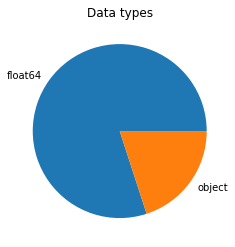

In [13]:
plot_dataframe_structure(df)

### Dataframe statistics

In [14]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
sepal.length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal.width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal.length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal.width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


Which columns could be categorical ?

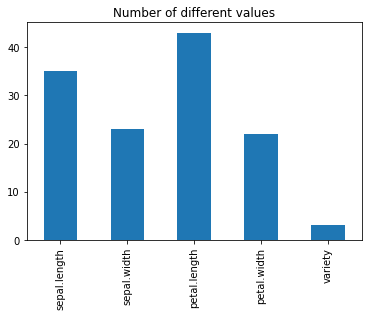

In [15]:
plot_categorical(df)

### Dataset Cleaning

#### Duplicate rows:

In [16]:
duplicates(df)

Number of rows before removing: 150
Number of duplicate rows: 1
Number of rows after removing: 149


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


#### Drop user's columns:

In [17]:
print('user_drop_cols = ', user_drop_cols)

user_drop_cols =  []


In [18]:
df = df.drop(user_drop_cols, axis=1)

#### Drop NaN:

In [19]:
df, drop_cols = drop_na(df, threshold_NaN)

No need to drop columns.


Final set of dropped columns

In [20]:
dropped_cols = np.unique(np.concatenate((drop_cols, user_drop_cols)))

In [21]:
display(dropped_cols)

array([], dtype=float64)

#### Encoding data:

In [22]:
df, encoded_cols = encoding(df, threshold_cat)

Encoding numeric column: sepal.length
Encoding numeric column: sepal.width
Encoding numeric column: petal.length
Encoding numeric column: petal.width
Encoding object column: variety


#### Imputing NaN using IterativeImputer

##### Imputation

In [23]:
df = imputation(df)

No need to impute data.


#### Data compression:

In [24]:
df = downcast_dtypes(df)

Memory usage of dataframe is 0.01MB
Memory usage after optimization is: 0.00MB
Decreased by 75.9%


Dataframe structure after compression

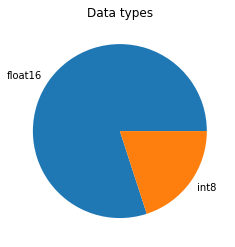

In [25]:
plot_dataframe_structure(df)

#### Outliers:

In [26]:
df = outliers(df, threshold_Z)

Using Z_score,  1  rows will be suppressed.


#### Splitting dataframe in features and targets

In [27]:
y = df[target_col]

In [28]:
X = df.drop(target_col, axis=1)

## Splitting data in train and test sets 

In [29]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.33)

## Modeling

### Building the model

Level-0 models

In [30]:
level_0 = [ 
          ( 'GPC' , GaussianProcessClassifier() ), 
          ( 'DTC' , DecisionTreeClassifier(max_depth=5) ), 
          ( 'RFC' , RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto') ), 
          ( 'ABC' , AdaBoostClassifier() ), 
          ( 'LOGR' , LogisticRegression() ), 
          ( 'MLPC' , MLPClassifier(alpha=1, max_iter=1000, early_stopping=True) ), 
          ( 'KNC' , KNeighborsClassifier(n_neighbors=len(y.unique())) ), 
          ( 'GNB' , GaussianNB() ), 
          ]

Level-1 model

In [31]:
level_1 = MLPClassifier()

Stacking for classification

In [32]:
model = StackingClassifier(level_0, final_estimator=level_1)

### Model fitting

In [33]:
%%time
set_config(display='diagram') 
model.fit(X_train, y_train)

CPU times: user 2.93 s, sys: 923 ms, total: 3.85 s
Wall time: 2.04 s


StackingClassifier(estimators=[('GPC', GaussianProcessClassifier()),
                               ('DTC', DecisionTreeClassifier(max_depth=5)),
                               ('RFC',
                                RandomForestClassifier(max_depth=5,
                                                       n_estimators=10)),
                               ('ABC', AdaBoostClassifier()),
                               ('LOGR', LogisticRegression()),
                               ('MLPC',
                                MLPClassifier(alpha=1, early_stopping=True,
                                              max_iter=1000)),
                               ('KNC', KNeighborsClassifier(n_neighbors=3)),
                               ('GNB', GaussianNB())],
                   final_estimator=MLPClassifier())

### Model evaluation

#### Model scoring

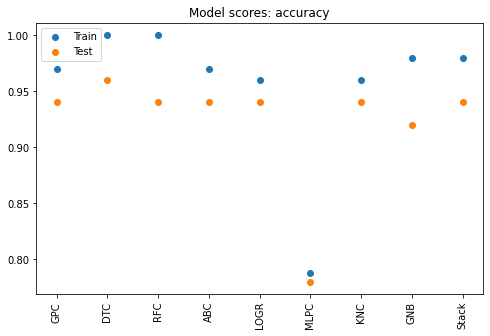

array([['GPC', 0.9696969696969697, 0.94],
       ['DTC', 1.0, 0.96],
       ['RFC', 1.0, 0.94],
       ['ABC', 0.9696969696969697, 0.94],
       ['LOGR', 0.9595959595959596, 0.94],
       ['MLPC', 0.7878787878787878, 0.78],
       ['KNC', 0.9595959595959596, 0.94],
       ['GNB', 0.9797979797979798, 0.92],
       ['Stack', 0.9797979797979798, 0.94]], dtype=object)

In [34]:
score_stacking_c(model, X_train, y_train, X_test, y_test)

#### Feature permutation importance (a posteriori)

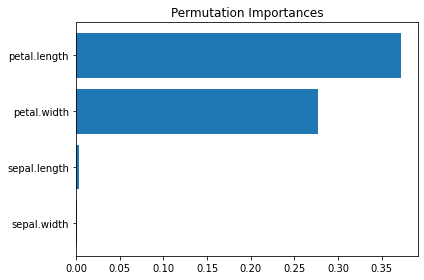

In [35]:
plot_perm_imp(model, X, y, scoring = 'accuracy');